# GAN exploration

### Dataset 
1. [TIME GAN](https://www.kaggle.com/code/faaizhashmi/generating-synthetic-data-apple-stock-using-gan)
- Generating synthetic data apple stock using GAN
2. [Medical Image Generation with GANs  ](https://www.kaggle.com/code/asif00/medical-image-generation-with-gans)
3. [GAN-On Tabular Data](https://www.kaggle.com/code/samanemami/gan-on-tabular-data)
4. [TTS-GAN](https://www.kaggle.com/code/fluentn/tts-gan/data)

# Data import - Image

In [1]:
# Import the required librairies 
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms, datasets
from torchvision.datasets import MNIST # Training dataset
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0) # Set for testing purposes, please do not change!

In [90]:
#initially I went for 128*128, later decided to go with 512*512 image size
BUFFER_SIZE = 12000
BATCH_SIZE = 24
EPOCHS = 50
latent_dim = 64
input_size = [128*2, 128*2, 1]
image_size = (14*2, 14*2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([24, 1, 28, 28])


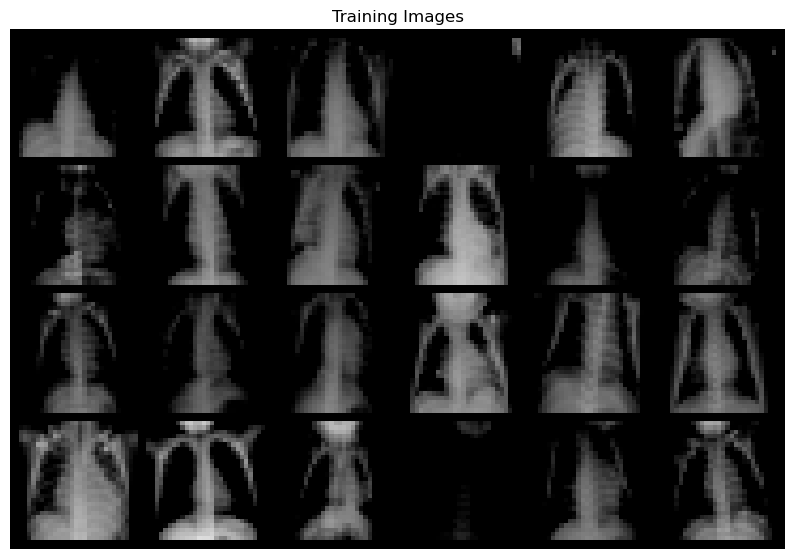

In [145]:
image_directory = '/Users/philippebeliveau/Desktop/Notebook_Jupyter_R/Synthetic_Data/GAN/chest_xray/train'

def filter_classes(file):
    # Liste des classes que vous voulez charger
    classes = ['NORMAL', 'PNEUMONIA']
    
    # Vérifier si le fichier appartient à l'une des classes spécifiées
    return any(cls in file for cls in classes)

# Définir les transformations à appliquer sur les images
# Define the transform
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5))
])


# Utiliser ImageFolder pour charger les images à partir du répertoire
dataset = datasets.ImageFolder(image_directory, transform=transform, is_valid_file=filter_classes)

# Utiliser DataLoader pour gérer le chargement des données en lots
train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

images, labels = next(iter(train_dataloader))
print(images.size())
# show images
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.title("Training Images")
plt.imshow(make_grid(images, nrow=6).permute((1, 2, 0)))


In [173]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

def make_grad_hook():
    '''
    Function to keep track of gradients for visualization purposes, 
    which fills the grads list when using model.apply(grad_hook).
    '''
    grads = []
    def grad_hook(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
            grads.append(m.weight.grad)
    return grads, grad_hook

# Deep convolutional GAN - Image
- Use convolutions without any pooling layers
- Use batchnorm in both the generator and the discriminator
- Don't use fully connected hidden layers
- Use ReLU activation in the generator for all layers except for the output, which uses a Tanh activation.
- Use LeakyReLU activation in the discriminator for all layers except for the output, which does not use an activation

In [185]:
class Generator(nn.Module): 
    '''
    Generator Class 
        z_dim: the dimension of the noise vector, a scalar
        im_chan: the number of channels of the output image, a scalar
        (MNIST is black-and-white, so 1 channel is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, z_dim=10, im_chan = 1, hidden_dim = 64): 
        super(Generator, self).__init__()
        self.z_dim = z_dim 
        # Build the layers
        self.gen = nn.Sequential(
            self.gen_block(z_dim, hidden_dim*4),
            self.gen_block(hidden_dim*4, hidden_dim*2, kernel_size=4, stride=1),
            self.gen_block(hidden_dim*2, hidden_dim),
            self.gen_block(hidden_dim, im_chan, kernel_size=4, final_layer = True)
        )
        
    def gen_block(self, in_channels, out_channels, kernel_size= 3, stride= 2, final_layer = False): 
        if not final_layer: 
            return nn.Sequential(
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size = kernel_size, stride = stride, bias = False), 
                nn.BatchNorm2d(out_channels), 
                nn.ReLU(inplace=True)
            )
        else: 
            return nn.Sequential(
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size = kernel_size, stride = stride, bias = False), 
                nn.Tanh()
            )
    def unsqueeze_noise(self, noise):  
        return noise.view(len(noise), self.z_dim, 1, 1)
    
    def forward(self, noise): 
        x = self.unsqueeze_noise(noise)
        return self.gen(x)


In [186]:
class Discriminator(nn.Module): 
    def __init__(self, im_chan = 1, hidden_dim = 16): 
        super(Discriminator, self).__init__()
        self.im_chan = im_chan
        # Build the neural network 
        self.disc = nn.Sequential(
            self.disc_block(im_chan, hidden_dim),
            self.disc_block(hidden_dim, hidden_dim*2),
            self.disc_block(hidden_dim*2, 1, final_layer = True)
        )

    def disc_block(self, in_channels, out_channels, kernel_size= 3, stride= 2, final_layer = False): 
        if not final_layer: 
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size, stride, bias = False), 
                nn.BatchNorm2d(out_channels), 
                nn.LeakyReLU(0.2, inplace=True)
            )
        else: 
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size, stride, bias = False), 
            )
    def forward(self, image):  
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)

## GAN class and training

In [202]:
display_step = 50

class GAN(nn.Module): 
    def __init__(self, z_dim, im_chan, hidden_dim): 
        super(GAN, self).__init__()

        beta_1 = 0.5
        beta_2 = 0.999
        lr = 0.0002

        self.z_dim = z_dim
        self.im_chan = im_chan
        self.hidden_dim = hidden_dim
        self.gen = Generator(z_dim)#, im_chan, hidden_dim)
        self.disc = Discriminator()
        self.gen_opt = torch.optim.Adam(self.gen.parameters(), lr = lr, betas = (beta_1, beta_2))
        self.disc_opt = torch.optim.Adam(self.disc.parameters(), lr = lr, betas = (beta_1, beta_2))
        self.criterion = nn.BCEWithLogitsLoss()

    # You initialize the weights to the normal distribution
    # with mean 0 and standard deviation 0.02
    def weights_init(self, m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
            torch.nn.init.normal_(m.weight, 0.0, 0.02)
        if isinstance(m, nn.BatchNorm2d):
            torch.nn.init.normal_(m.weight, 0.0, 0.02)
            torch.nn.init.constant_(m.bias, 0)

    def train_step(self, train_dataloader, display_step, cur_step):

        EPOCHS = 25
        display_step = 500
        cur_step = 0
        device = 'cpu'
        gen = self.gen.to(device)
        disc = self.disc.to(device)
        mean_discriminator_loss = 0
        mean_generator_loss = 0
    
        gen = self.gen.apply(self.weights_init)
        disc = self.disc.apply(self.weights_init)
        
        for epoch in range(EPOCHS):
            #real_images, real_labels = next(iter(train_dataloader))
            for real_images, _ in tqdm(train_dataloader):
                
                real = real_images.to(device)
                batch_size = len(real_images)
                # Real images
                noise = torch.randn(batch_size, self.z_dim)
                # Generate fake images
                generated_images = gen(noise)

                criterion = self.criterion

                # Train the discriminator
                disc_opt = self.disc_opt
                disc_opt.zero_grad()
                disc_fake_pred = disc(generated_images.detach())
                disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
                
                disc_real_pred = disc(real_images)
                disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
                disc_losses = (disc_fake_loss + disc_real_loss) / 2
                disc_losses.backward(retain_graph=True)
                disc_opt.step()

                # Keep track of the average discriminator loss
                mean_discriminator_loss += disc_losses.item() / display_step

                # Train the generator
                gen_opt = self.gen_opt
                gen_opt.zero_grad()
                generator = self.gen
                fake_2 = generator(noise)
                disc_fake_pred = self.disc(fake_2)
                generator_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
                generator_loss.backward()
                gen_opt.step()

                # Keep track of the average generator loss
                mean_generator_loss += generator_loss.item() / display_step
                
                # Print losses
                print(f"Discriminator loss: {mean_discriminator_loss}, generator loss: {mean_generator_loss}")

                ## Visualization code ##
                if cur_step % display_step == 0 and cur_step > 0:
                    print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
                    show_tensor_images(generated_images)
                    show_tensor_images(real)
                    mean_generator_loss = 0
                    mean_discriminator_loss = 0
                cur_step += 1

  0%|          | 0/218 [00:00<?, ?it/s]

Discriminator loss: 0.001385964870452881, generator loss: 0.0013861886262893676
Discriminator loss: 0.002771822690963745, generator loss: 0.0027721579074859617
Discriminator loss: 0.004157554864883423, generator loss: 0.004157922029495239
Discriminator loss: 0.0055431643724441525, generator loss: 0.005543564438819886
Discriminator loss: 0.006928705096244812, generator loss: 0.006928914070129395
Discriminator loss: 0.008314158797264099, generator loss: 0.008314026832580567
Discriminator loss: 0.009699592590332031, generator loss: 0.00969890069961548
Discriminator loss: 0.011084978580474854, generator loss: 0.011083476543426516
Discriminator loss: 0.012470270037651063, generator loss: 0.012467879414558413
Discriminator loss: 0.01385553801059723, generator loss: 0.01385206174850464
Discriminator loss: 0.01524073922634125, generator loss: 0.015236022949218752
Discriminator loss: 0.016625939011573793, generator loss: 0.016619873046875
Discriminator loss: 0.01801104295253754, generator loss:

  0%|          | 0/218 [00:00<?, ?it/s]

Discriminator loss: 0.2985131813287738, generator loss: 0.30019109857082366
Discriminator loss: 0.29987199938297304, generator loss: 0.30158136653900147
Discriminator loss: 0.301230646491051, generator loss: 0.3029529347419739
Discriminator loss: 0.30259077048301725, generator loss: 0.30433121502399446
Discriminator loss: 0.30395125651359584, generator loss: 0.3056914510726929
Discriminator loss: 0.30531291651725795, generator loss: 0.30707075405120854
Discriminator loss: 0.3066743513345721, generator loss: 0.30840939223766334
Discriminator loss: 0.308042796969414, generator loss: 0.3097826459407807
Discriminator loss: 0.30940737688541436, generator loss: 0.3111295793056489
Discriminator loss: 0.31077493345737484, generator loss: 0.3125006730556489
Discriminator loss: 0.3121432172060015, generator loss: 0.31383971750736245
Discriminator loss: 0.3135197657346728, generator loss: 0.3151707876920701
Discriminator loss: 0.31490007698535943, generator loss: 0.3165043985843659
Discriminator 

  0%|          | 0/218 [00:00<?, ?it/s]

Discriminator loss: 0.5987622668743132, generator loss: 0.5998867628574377
Discriminator loss: 0.6001541216373443, generator loss: 0.6012594577074056
Discriminator loss: 0.6015427374839781, generator loss: 0.602643378257752
Discriminator loss: 0.6029314925670622, generator loss: 0.6040367444753653
Discriminator loss: 0.6043181599378584, generator loss: 0.6054350627660757
Discriminator loss: 0.6057063019275664, generator loss: 0.60681798362732
Discriminator loss: 0.6071106779575346, generator loss: 0.6081805082559592
Discriminator loss: 0.60851540851593, generator loss: 0.6095582625865942
Discriminator loss: 0.6099161639213561, generator loss: 0.6109357936382299
Discriminator loss: 0.6113086912631988, generator loss: 0.612306968927384
Discriminator loss: 0.6126999268531799, generator loss: 0.6136747195720679
Discriminator loss: 0.6140986778736114, generator loss: 0.6150290347337729
Discriminator loss: 0.6155067645311355, generator loss: 0.616377625584603
Discriminator loss: 0.6169145934

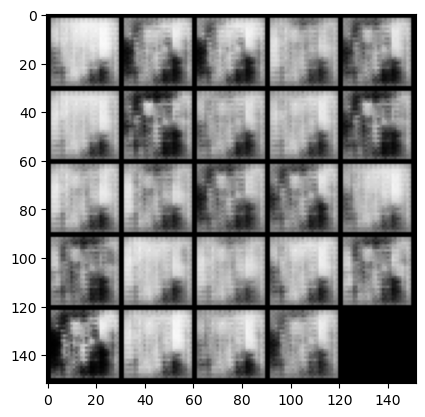

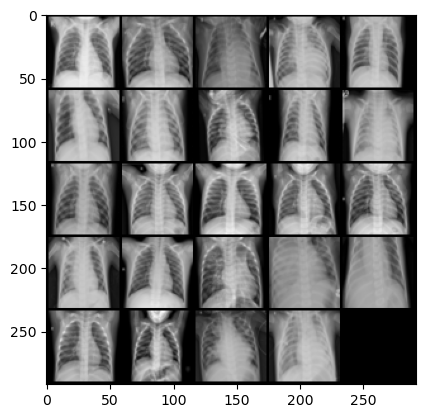

Discriminator loss: 0.0013863911628723144, generator loss: 0.001397903323173523
Discriminator loss: 0.002773376226425171, generator loss: 0.00279488205909729
Discriminator loss: 0.004158695220947265, generator loss: 0.004196580648422241
Discriminator loss: 0.005543556094169616, generator loss: 0.005595997929573059
Discriminator loss: 0.006927128195762634, generator loss: 0.006997334957122803
Discriminator loss: 0.008310298681259154, generator loss: 0.00839693319797516
Discriminator loss: 0.00969566774368286, generator loss: 0.009793376088142396
Discriminator loss: 0.011080572605133055, generator loss: 0.011188575506210328
Discriminator loss: 0.012467044115066528, generator loss: 0.012577604532241823
Discriminator loss: 0.013855959177017211, generator loss: 0.013959866762161256
Discriminator loss: 0.01524347162246704, generator loss: 0.015343380808830262
Discriminator loss: 0.016630718827247617, generator loss: 0.01672628676891327
Discriminator loss: 0.018018539071083067, generator loss

  0%|          | 0/218 [00:00<?, ?it/s]

Discriminator loss: 0.21404819452762605, generator loss: 0.21491036152839657
Discriminator loss: 0.21544394969940187, generator loss: 0.21629608786106105
Discriminator loss: 0.2168401950597763, generator loss: 0.21768249440193171
Discriminator loss: 0.2182357429265976, generator loss: 0.2190703074932098
Discriminator loss: 0.21962901175022123, generator loss: 0.22046127438545224
Discriminator loss: 0.22102110445499418, generator loss: 0.22185633540153502
Discriminator loss: 0.22241240274906157, generator loss: 0.22325169205665588
Discriminator loss: 0.22380372798442838, generator loss: 0.22465009427070617
Discriminator loss: 0.22519506990909574, generator loss: 0.2260490162372589
Discriminator loss: 0.22658429729938503, generator loss: 0.22745284581184386
Discriminator loss: 0.22797349011898038, generator loss: 0.22885927927494049
Discriminator loss: 0.2293610697984695, generator loss: 0.23026819586753844
Discriminator loss: 0.23074787104129788, generator loss: 0.2316796370744705
Discr

  0%|          | 0/218 [00:00<?, ?it/s]

Discriminator loss: 0.5169685910940166, generator loss: 0.5188421719074248
Discriminator loss: 0.518356438040733, generator loss: 0.5202497497797011
Discriminator loss: 0.5197451430559155, generator loss: 0.521655164837837
Discriminator loss: 0.5211321464776989, generator loss: 0.523063433408737
Discriminator loss: 0.5225217683315273, generator loss: 0.5244665467739102
Discriminator loss: 0.523910274982452, generator loss: 0.5258708446025846
Discriminator loss: 0.5253000864982601, generator loss: 0.5272745721340177
Discriminator loss: 0.5266878404617306, generator loss: 0.5286799260377882
Discriminator loss: 0.5280764520168301, generator loss: 0.530083748936653
Discriminator loss: 0.5294645456075665, generator loss: 0.5314874039888381
Discriminator loss: 0.530853734374046, generator loss: 0.5328889147043228
Discriminator loss: 0.5322406440973279, generator loss: 0.5342932021617889
Discriminator loss: 0.5336291743516919, generator loss: 0.5356947354078292
Discriminator loss: 0.535016937

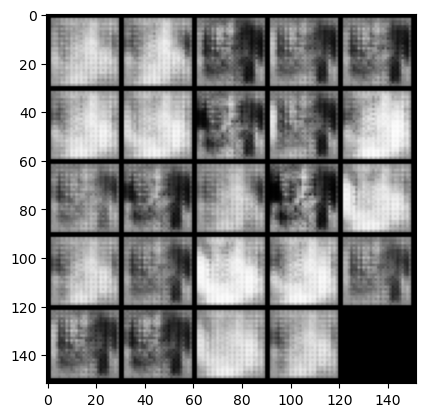

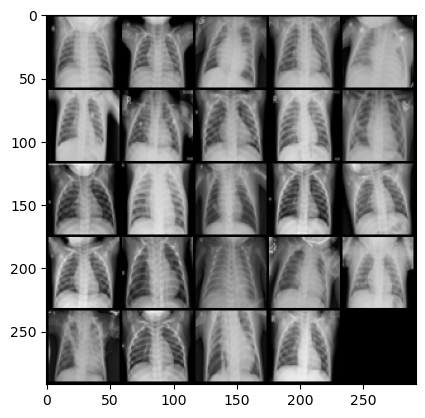

Discriminator loss: 0.001389833688735962, generator loss: 0.0013858178853988648
Discriminator loss: 0.00277925443649292, generator loss: 0.00277214527130127
Discriminator loss: 0.004169327378273011, generator loss: 0.0041576577425003055
Discriminator loss: 0.005558456778526307, generator loss: 0.005544079422950745
Discriminator loss: 0.006947656393051148, generator loss: 0.006929425477981568
Discriminator loss: 0.008336306214332581, generator loss: 0.00831541645526886
Discriminator loss: 0.009724996447563172, generator loss: 0.009700910687446595
Discriminator loss: 0.011113213181495668, generator loss: 0.011086607575416565
Discriminator loss: 0.01250150513648987, generator loss: 0.012471105337142945
Discriminator loss: 0.013889153957366944, generator loss: 0.013856140971183779
Discriminator loss: 0.015276992082595826, generator loss: 0.015241238474845889
Discriminator loss: 0.01666484045982361, generator loss: 0.016625886201858522
Discriminator loss: 0.018053043127059937, generator los

  0%|          | 0/218 [00:00<?, ?it/s]

Discriminator loss: 0.12489815318584445, generator loss: 0.12479169011116029
Discriminator loss: 0.12628684568405155, generator loss: 0.12617237794399264
Discriminator loss: 0.12767549836635592, generator loss: 0.12755294501781467
Discriminator loss: 0.12906508147716525, generator loss: 0.12893135440349582
Discriminator loss: 0.13045405352115633, generator loss: 0.13031047856807712
Discriminator loss: 0.13184201753139496, generator loss: 0.13169080591201784
Discriminator loss: 0.13323028242588045, generator loss: 0.13307125246524812
Discriminator loss: 0.1346177343130112, generator loss: 0.13445199012756348
Discriminator loss: 0.13600460553169252, generator loss: 0.13583444941043854
Discriminator loss: 0.1373906227350235, generator loss: 0.13721769785881044
Discriminator loss: 0.138777694106102, generator loss: 0.13859797298908236
Discriminator loss: 0.14016452372074129, generator loss: 0.13997815918922427
Discriminator loss: 0.1415513929128647, generator loss: 0.14135746359825135
Disc

  0%|          | 0/218 [00:00<?, ?it/s]

Discriminator loss: 0.4273208994865416, generator loss: 0.4270796401500703
Discriminator loss: 0.42870879435539233, generator loss: 0.4284670768976213
Discriminator loss: 0.43009681975841507, generator loss: 0.4298544166088106
Discriminator loss: 0.43148503553867323, generator loss: 0.4312412436008455
Discriminator loss: 0.43287309122085554, generator loss: 0.4326282643079759
Discriminator loss: 0.4342614485025404, generator loss: 0.4340150089263917
Discriminator loss: 0.4356497474908827, generator loss: 0.43540153217315686
Discriminator loss: 0.43703792369365674, generator loss: 0.436788787007332
Discriminator loss: 0.4384260574579237, generator loss: 0.43817630887031567
Discriminator loss: 0.4398134254217146, generator loss: 0.43956529009342205
Discriminator loss: 0.44120028603076916, generator loss: 0.4409550482034684
Discriminator loss: 0.44258663618564587, generator loss: 0.44234413862228406
Discriminator loss: 0.44397125375270824, generator loss: 0.44373397672176373
Discriminator

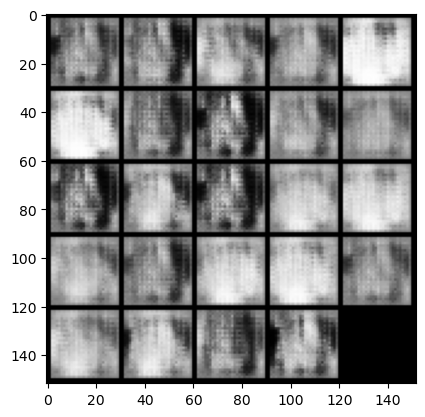

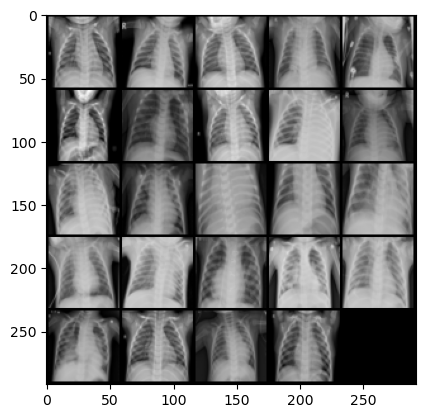

Discriminator loss: 0.0013863961696624755, generator loss: 0.0013896995782852173
Discriminator loss: 0.002772392153739929, generator loss: 0.002779981732368469
Discriminator loss: 0.004158259510993957, generator loss: 0.004170340061187744
Discriminator loss: 0.005544438242912292, generator loss: 0.0055596443414688106
Discriminator loss: 0.006930380821228027, generator loss: 0.006949515104293823
Discriminator loss: 0.008316943168640137, generator loss: 0.008337777376174926
Discriminator loss: 0.009702893495559693, generator loss: 0.009727407336235045
Discriminator loss: 0.011089671969413758, generator loss: 0.011115445971488952
Discriminator loss: 0.012476995825767518, generator loss: 0.012502774596214293
Discriminator loss: 0.013863880753517152, generator loss: 0.01389117121696472
Discriminator loss: 0.015250286221504213, generator loss: 0.015280619859695432
Discriminator loss: 0.01663750755786896, generator loss: 0.01666967666149139
Discriminator loss: 0.01802499604225159, generator l

  0%|          | 0/218 [00:00<?, ?it/s]

Discriminator loss: 0.03604995870590209, generator loss: 0.03612542927265167
Discriminator loss: 0.03743917942047118, generator loss: 0.03750609731674194
Discriminator loss: 0.038828943967819204, generator loss: 0.03888550174236297
Discriminator loss: 0.0402193191051483, generator loss: 0.04026476120948791
Discriminator loss: 0.04160999822616576, generator loss: 0.041644982933998105
Discriminator loss: 0.04300087428092956, generator loss: 0.0430258651971817
Discriminator loss: 0.044391014099121086, generator loss: 0.04440932583808899
Discriminator loss: 0.04578074383735656, generator loss: 0.04579422867298126
Discriminator loss: 0.04716956877708434, generator loss: 0.0471813827753067
Discriminator loss: 0.04855763554573058, generator loss: 0.04857019400596618
Discriminator loss: 0.04994470739364623, generator loss: 0.049960726141929625
Discriminator loss: 0.05133107829093932, generator loss: 0.05135244739055633
Discriminator loss: 0.052716448307037346, generator loss: 0.052745394587516

  0%|          | 0/218 [00:00<?, ?it/s]

Discriminator loss: 0.3385095443725584, generator loss: 0.3389646750688553
Discriminator loss: 0.3398975126743315, generator loss: 0.3403501586914063
Discriminator loss: 0.341286121368408, generator loss: 0.34173518085479737
Discriminator loss: 0.3426749970912932, generator loss: 0.34311982691287995
Discriminator loss: 0.34406371974945055, generator loss: 0.34450578927993775
Discriminator loss: 0.3454524354934691, generator loss: 0.3458917775154114
Discriminator loss: 0.3468414775133132, generator loss: 0.347277506351471
Discriminator loss: 0.34823024213314047, generator loss: 0.34866372668743134
Discriminator loss: 0.3496193970441817, generator loss: 0.3500494997501373
Discriminator loss: 0.35100840079784384, generator loss: 0.3514359749555588
Discriminator loss: 0.3523976035118102, generator loss: 0.35282297456264494
Discriminator loss: 0.3537862982749938, generator loss: 0.3542112872600555
Discriminator loss: 0.355175260901451, generator loss: 0.3555988458395004
Discriminator loss: 

  0%|          | 0/218 [00:00<?, ?it/s]

Discriminator loss: 0.64093819797039, generator loss: 0.6414460228681566
Discriminator loss: 0.6423338276147839, generator loss: 0.642818898677826
Discriminator loss: 0.6437300314903256, generator loss: 0.6441919807195665
Discriminator loss: 0.6451262781620022, generator loss: 0.6455666127204897
Discriminator loss: 0.6465207862854, generator loss: 0.6469451986551287
Discriminator loss: 0.6479135808944698, generator loss: 0.6483273260593416
Discriminator loss: 0.6493049533367153, generator loss: 0.6497124308347704
Discriminator loss: 0.6506944909095761, generator loss: 0.6511004812717439
Discriminator loss: 0.6520828466415403, generator loss: 0.6524912239313126
Discriminator loss: 0.6534698528051374, generator loss: 0.6538854138851167
Discriminator loss: 0.6548555175065992, generator loss: 0.6552818812131883
Discriminator loss: 0.6562399781942365, generator loss: 0.656680300474167
Discriminator loss: 0.6576236463785169, generator loss: 0.6580802066326144
Discriminator loss: 0.6590061889

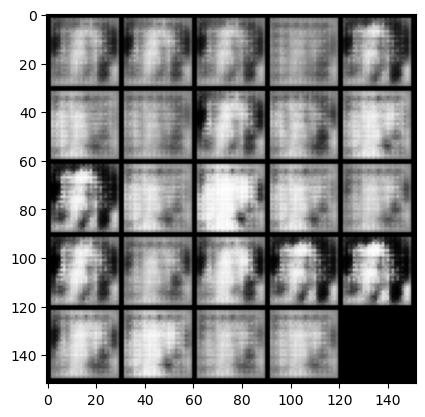

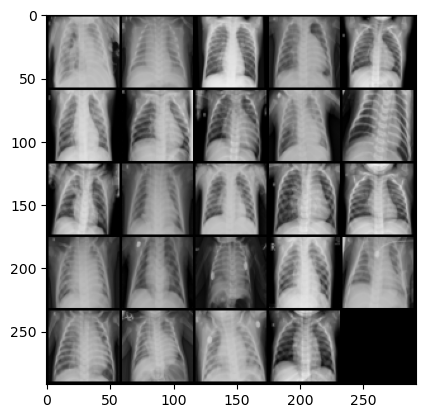

Discriminator loss: 0.0013875157833099364, generator loss: 0.0013919073343276979
Discriminator loss: 0.002774779915809631, generator loss: 0.0027850122451782227
Discriminator loss: 0.004161809086799621, generator loss: 0.004178900718688965
Discriminator loss: 0.005549681782722473, generator loss: 0.005572137475013733
Discriminator loss: 0.006937195658683776, generator loss: 0.006965667366981506
Discriminator loss: 0.008325750231742857, generator loss: 0.008358309030532836
Discriminator loss: 0.00971464431285858, generator loss: 0.00975055956840515
Discriminator loss: 0.011104075074195861, generator loss: 0.011141795873641967
Discriminator loss: 0.01249442970752716, generator loss: 0.01253171455860138
Discriminator loss: 0.013885509848594664, generator loss: 0.013919672012329102
Discriminator loss: 0.015276898264884948, generator loss: 0.015307284474372865
Discriminator loss: 0.016669249176979064, generator loss: 0.016693143129348754
Discriminator loss: 0.018062209725379943, generator l

  0%|          | 0/218 [00:00<?, ?it/s]

Discriminator loss: 0.24969922518730145, generator loss: 0.2497443190813065
Discriminator loss: 0.25108910357952097, generator loss: 0.25112382483482365
Discriminator loss: 0.25247912323474864, generator loss: 0.2525038287639618
Discriminator loss: 0.2538685880899427, generator loss: 0.2538853677511215
Discriminator loss: 0.2552579742670057, generator loss: 0.255267822265625
Discriminator loss: 0.256646895766258, generator loss: 0.2566511059999466
Discriminator loss: 0.25803619539737677, generator loss: 0.25803503715991977
Discriminator loss: 0.2594244900941846, generator loss: 0.25942044556140903
Discriminator loss: 0.2608124524354932, generator loss: 0.26080637574195864
Discriminator loss: 0.26220035493373844, generator loss: 0.2621929606199265
Discriminator loss: 0.2635882779359815, generator loss: 0.2635800726413727
Discriminator loss: 0.26497585856914496, generator loss: 0.26496806168556214
Discriminator loss: 0.2663631381988523, generator loss: 0.26635692656040194
Discriminator l

  0%|          | 0/218 [00:00<?, ?it/s]

Discriminator loss: 0.5519832051992415, generator loss: 0.5522502295970919
Discriminator loss: 0.5533676010370253, generator loss: 0.5536423118114474
Discriminator loss: 0.5547514226436614, generator loss: 0.5550349854230884
Discriminator loss: 0.5561352326869964, generator loss: 0.5564275622367862
Discriminator loss: 0.5575194606781005, generator loss: 0.5578195471763614
Discriminator loss: 0.5589041351079941, generator loss: 0.5592099438905719
Discriminator loss: 0.5602887488603592, generator loss: 0.5606003862619403
Discriminator loss: 0.5616732784509658, generator loss: 0.5619903366565707
Discriminator loss: 0.5630576993227004, generator loss: 0.5633802877664569
Discriminator loss: 0.5644424902200699, generator loss: 0.5647696920633318
Discriminator loss: 0.5658281321525573, generator loss: 0.566156971216202
Discriminator loss: 0.5672141406536102, generator loss: 0.5675433777570726
Discriminator loss: 0.5686017258167266, generator loss: 0.5689268851280215
Discriminator loss: 0.5699

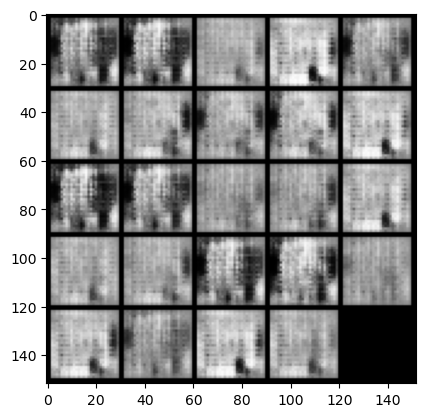

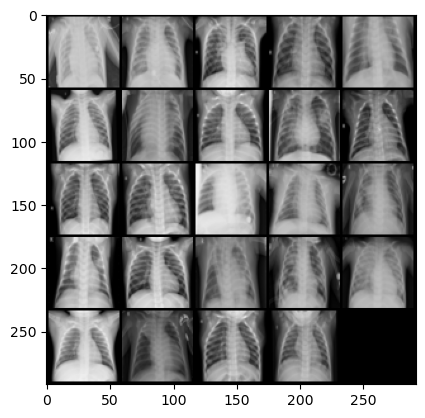

Discriminator loss: 0.0013889553546905518, generator loss: 0.0013795448541641235
Discriminator loss: 0.0027786835432052613, generator loss: 0.0027588849067687986
Discriminator loss: 0.004167699694633484, generator loss: 0.00413956081867218
Discriminator loss: 0.005556979775428772, generator loss: 0.005520396828651428
Discriminator loss: 0.006946182608604431, generator loss: 0.006901989698410034
Discriminator loss: 0.008334545969963074, generator loss: 0.008285133957862853
Discriminator loss: 0.009722710371017455, generator loss: 0.009669663429260253
Discriminator loss: 0.01111046552658081, generator loss: 0.011056021332740782
Discriminator loss: 0.012497903227806091, generator loss: 0.012443346261978148
Discriminator loss: 0.013884734153747559, generator loss: 0.013831944346427916
Discriminator loss: 0.015271171927452087, generator loss: 0.015221411943435667
Discriminator loss: 0.01665688610076904, generator loss: 0.016612226724624632
Discriminator loss: 0.018042051076889037, generator

  0%|          | 0/218 [00:00<?, ?it/s]

Discriminator loss: 0.1608221619129181, generator loss: 0.16080775988101964
Discriminator loss: 0.16221072268486023, generator loss: 0.16218507313728336
Discriminator loss: 0.1636001913547516, generator loss: 0.16356073987483982
Discriminator loss: 0.16499091351032258, generator loss: 0.16493506574630742
Discriminator loss: 0.166382252573967, generator loss: 0.16630908238887793
Discriminator loss: 0.1677737182378769, generator loss: 0.16768395662307745
Discriminator loss: 0.16916613948345186, generator loss: 0.1690590325593949
Discriminator loss: 0.17055740094184876, generator loss: 0.17043769669532782
Discriminator loss: 0.17194862866401672, generator loss: 0.1718174463510514
Discriminator loss: 0.17333940291404723, generator loss: 0.17319927072525032
Discriminator loss: 0.17472948336601257, generator loss: 0.174583986401558
Discriminator loss: 0.17611885023117066, generator loss: 0.17597091591358194
Discriminator loss: 0.1775069978237152, generator loss: 0.1773613619804383
Discrimina

  0%|          | 0/218 [00:00<?, ?it/s]

Discriminator loss: 0.46322974658012395, generator loss: 0.4628340910673142
Discriminator loss: 0.46461386680603034, generator loss: 0.46423002362251287
Discriminator loss: 0.46599829149246225, generator loss: 0.46562587392330174
Discriminator loss: 0.4673828055858613, generator loss: 0.46702098786830903
Discriminator loss: 0.4687670133113862, generator loss: 0.4684164378643036
Discriminator loss: 0.4701512906551362, generator loss: 0.4698110047578812
Discriminator loss: 0.4715357258319856, generator loss: 0.4712053396701813
Discriminator loss: 0.4729204456806184, generator loss: 0.47259970247745514
Discriminator loss: 0.4743050994873048, generator loss: 0.4739939676523209
Discriminator loss: 0.47569044649600994, generator loss: 0.475386864900589
Discriminator loss: 0.4770757704973222, generator loss: 0.47677855610847475
Discriminator loss: 0.47846089458465585, generator loss: 0.4781704107522965
Discriminator loss: 0.47984666144847876, generator loss: 0.4795607447624207
Discriminator l

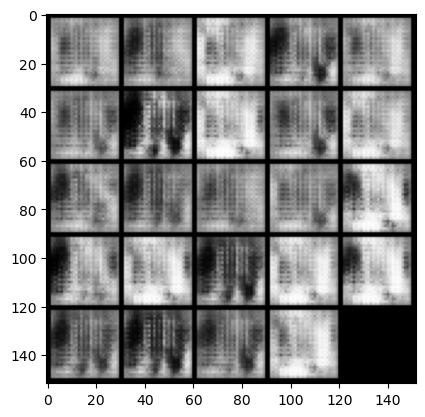

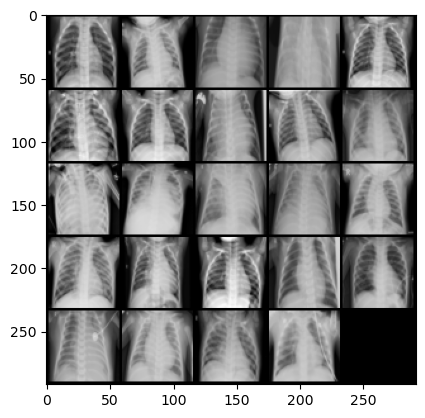

Discriminator loss: 0.0013806452751159667, generator loss: 0.0013941893577575685
Discriminator loss: 0.0027621529102325438, generator loss: 0.0027865856885910035
Discriminator loss: 0.004145776033401489, generator loss: 0.0041741646528244015
Discriminator loss: 0.005531801700592041, generator loss: 0.005557416319847106
Discriminator loss: 0.006918204069137573, generator loss: 0.0069390544891357415
Discriminator loss: 0.008306984066963195, generator loss: 0.008316662788391112
Discriminator loss: 0.00969476294517517, generator loss: 0.009696642279624938
Discriminator loss: 0.011084548234939574, generator loss: 0.011072667837142943
Discriminator loss: 0.012476071834564208, generator loss: 0.01244556152820587
Discriminator loss: 0.01386887001991272, generator loss: 0.013816763877868652
Discriminator loss: 0.01526157832145691, generator loss: 0.015188578248023986
Discriminator loss: 0.01665509808063507, generator loss: 0.01655893063545227
Discriminator loss: 0.018048479914665225, generator 

  0%|          | 0/218 [00:00<?, ?it/s]

Discriminator loss: 0.07215412378311158, generator loss: 0.07198535454273222
Discriminator loss: 0.07354056143760682, generator loss: 0.07337083876132963
Discriminator loss: 0.07492754364013672, generator loss: 0.0747553001642227
Discriminator loss: 0.0763161199092865, generator loss: 0.07613643383979796
Discriminator loss: 0.07770435547828673, generator loss: 0.07751846587657926
Discriminator loss: 0.07909175348281859, generator loss: 0.07890214335918425
Discriminator loss: 0.08048038625717162, generator loss: 0.08028378772735593
Discriminator loss: 0.08187018716335295, generator loss: 0.08166292798519133
Discriminator loss: 0.08326042997837066, generator loss: 0.08304169392585753
Discriminator loss: 0.08464902937412261, generator loss: 0.0844238188266754
Discriminator loss: 0.08603842067718505, generator loss: 0.08580460083484649
Discriminator loss: 0.08742732429504393, generator loss: 0.08718576502799988
Discriminator loss: 0.08881596553325652, generator loss: 0.0885668078660965
Dis

  0%|          | 0/218 [00:00<?, ?it/s]

Discriminator loss: 0.374504210114479, generator loss: 0.37455869758129134
Discriminator loss: 0.3758937751054763, generator loss: 0.3759415204524995
Discriminator loss: 0.3772830079793929, generator loss: 0.3773244200944902
Discriminator loss: 0.3786719570159911, generator loss: 0.3787078108787538
Discriminator loss: 0.3800609881877898, generator loss: 0.3800908049345018
Discriminator loss: 0.3814491255283355, generator loss: 0.38147510933876055
Discriminator loss: 0.3828366153240203, generator loss: 0.38286060166358965
Discriminator loss: 0.38422386729717245, generator loss: 0.384246637940407
Discriminator loss: 0.3856111344099044, generator loss: 0.3856326467990877
Discriminator loss: 0.3869984632730483, generator loss: 0.38701850402355215
Discriminator loss: 0.38838511025905603, generator loss: 0.3884053263664248
Discriminator loss: 0.3897716971635818, generator loss: 0.3897923642396929
Discriminator loss: 0.39115799653530114, generator loss: 0.3911800673007967
Discriminator loss: 

  0%|          | 0/218 [00:00<?, ?it/s]

Discriminator loss: 0.6767713278532027, generator loss: 0.6769305444955821
Discriminator loss: 0.6781579529047012, generator loss: 0.6783146443367
Discriminator loss: 0.67954516851902, generator loss: 0.6796983352899547
Discriminator loss: 0.6809320811033248, generator loss: 0.6810820733308788
Discriminator loss: 0.6823197031021118, generator loss: 0.6824641805887218
Discriminator loss: 0.6837077952623367, generator loss: 0.6838454457521435
Discriminator loss: 0.6850963380336761, generator loss: 0.6852259079217907
Discriminator loss: 0.6864855705499648, generator loss: 0.686605269193649
Discriminator loss: 0.6878747806549071, generator loss: 0.6879847472906109
Discriminator loss: 0.6892640841007232, generator loss: 0.6893637012243267
Discriminator loss: 0.6906538231372832, generator loss: 0.6907420305013653
Discriminator loss: 0.6920433030128478, generator loss: 0.6921206620931621
Discriminator loss: 0.6934326909780502, generator loss: 0.693499435305595
Step 3500: Generator loss: 0.693

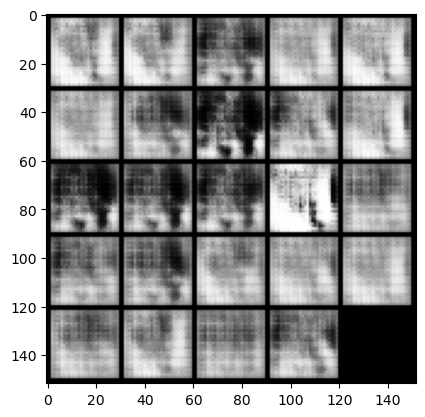

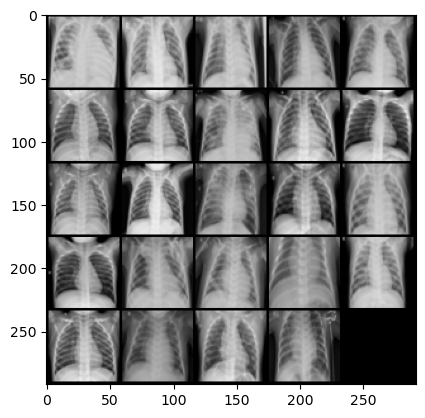

Discriminator loss: 0.0013891373872756958, generator loss: 0.001379482626914978
Discriminator loss: 0.0027779059410095214, generator loss: 0.002759222984313965
Discriminator loss: 0.004166664600372315, generator loss: 0.004139566898345947
Discriminator loss: 0.005554760336875916, generator loss: 0.00552049696445465
Discriminator loss: 0.006942941904067993, generator loss: 0.006901435017585754
Discriminator loss: 0.008331036567687989, generator loss: 0.008282571077346802
Discriminator loss: 0.00971924924850464, generator loss: 0.009663859486579895
Discriminator loss: 0.011107113838195803, generator loss: 0.011045798540115356
Discriminator loss: 0.01249470639228821, generator loss: 0.012427902340888976
Discriminator loss: 0.013882194042205812, generator loss: 0.013809791088104248
Discriminator loss: 0.015269692897796632, generator loss: 0.015192199349403381
Discriminator loss: 0.01665690040588379, generator loss: 0.01657464897632599
Discriminator loss: 0.018044032692909242, generator los

  0%|          | 0/218 [00:00<?, ?it/s]

Discriminator loss: 0.2856883268356321, generator loss: 0.2854841721057893
Discriminator loss: 0.2870765027999876, generator loss: 0.28686891520023355
Discriminator loss: 0.28846454858779885, generator loss: 0.2882539869546891
Discriminator loss: 0.28985234653949715, generator loss: 0.2896396551132203
Discriminator loss: 0.29123986721038797, generator loss: 0.2910257205963136
Discriminator loss: 0.29262708234786966, generator loss: 0.29241248238086714
Discriminator loss: 0.29401399493217445, generator loss: 0.2937998982667924
Discriminator loss: 0.29540079665184, generator loss: 0.29518729472160354
Discriminator loss: 0.296787449121475, generator loss: 0.2965748940706254
Discriminator loss: 0.29817351555824256, generator loss: 0.2979635878801347
Discriminator loss: 0.2995597522258756, generator loss: 0.29935179400444045
Discriminator loss: 0.3009455970525739, generator loss: 0.3007407404184343
Discriminator loss: 0.302331613898277, generator loss: 0.30212927353382124
Discriminator loss

  0%|          | 0/218 [00:00<?, ?it/s]

Discriminator loss: 0.5879970582723613, generator loss: 0.5878545668125155
Discriminator loss: 0.5893841786384577, generator loss: 0.5892413853406908
Discriminator loss: 0.5907710676193232, generator loss: 0.5906287105083468
Discriminator loss: 0.5921578471660609, generator loss: 0.5920159318447115
Discriminator loss: 0.59354467010498, generator loss: 0.5934033024311067
Discriminator loss: 0.5949315618276592, generator loss: 0.5947905753850938
Discriminator loss: 0.596318215489387, generator loss: 0.5961779048442842
Discriminator loss: 0.5977047828435893, generator loss: 0.5975653321743013
Discriminator loss: 0.5990912925004954, generator loss: 0.5989528892040255
Discriminator loss: 0.6004776843786235, generator loss: 0.6003404022455218
Discriminator loss: 0.6018641146421427, generator loss: 0.6017280294895174
Discriminator loss: 0.6032502728700633, generator loss: 0.6031156646013262
Discriminator loss: 0.6046368244886393, generator loss: 0.6045023832321169
Discriminator loss: 0.606023

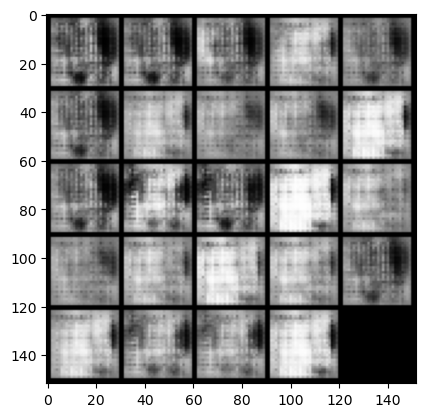

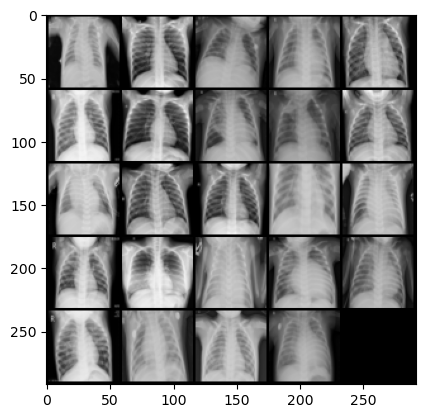

Discriminator loss: 0.0013863251209259033, generator loss: 0.0013854694366455078
Discriminator loss: 0.002772459983825684, generator loss: 0.0027713793516159057
Discriminator loss: 0.0041587924957275394, generator loss: 0.004157313823699951
Discriminator loss: 0.005544922113418579, generator loss: 0.005543419361114502
Discriminator loss: 0.006931222915649414, generator loss: 0.00692948579788208
Discriminator loss: 0.008317071437835694, generator loss: 0.008316452860832215
Discriminator loss: 0.009703179359436036, generator loss: 0.009703304767608643
Discriminator loss: 0.011089047193527223, generator loss: 0.011090302467346191
Discriminator loss: 0.012475163221359255, generator loss: 0.0124770268201828
Discriminator loss: 0.013861205101013185, generator loss: 0.013863784074783326
Discriminator loss: 0.015247383594512942, generator loss: 0.015250327944755554
Discriminator loss: 0.016633621335029606, generator loss: 0.01663654887676239
Discriminator loss: 0.018019944071769718, generator 

  0%|          | 0/218 [00:00<?, ?it/s]

Discriminator loss: 0.19686607801914213, generator loss: 0.1968361703157425
Discriminator loss: 0.1982528063058853, generator loss: 0.19822179329395295
Discriminator loss: 0.19963946616649625, generator loss: 0.19960755729675295
Discriminator loss: 0.20102641308307645, generator loss: 0.200992750287056
Discriminator loss: 0.2024131039381027, generator loss: 0.20237805509567264
Discriminator loss: 0.20379994428157802, generator loss: 0.20376327621936802
Discriminator loss: 0.2051865216493606, generator loss: 0.20514866650104527
Discriminator loss: 0.2065733741521835, generator loss: 0.2065338664054871
Discriminator loss: 0.2079602808952331, generator loss: 0.20791886425018313
Discriminator loss: 0.20934700155258174, generator loss: 0.20930421352386477
Discriminator loss: 0.2107337799072265, generator loss: 0.21068961560726168
Discriminator loss: 0.2121203663349151, generator loss: 0.21207506072521212
Discriminator loss: 0.21350685083866114, generator loss: 0.21346077656745913
Discrimina

  0%|          | 0/218 [00:00<?, ?it/s]

Discriminator loss: 0.4990855989456177, generator loss: 0.49903278791904443
Discriminator loss: 0.5004722952842713, generator loss: 0.5004181461334228
Discriminator loss: 0.5018592648506165, generator loss: 0.5018033280372619
Discriminator loss: 0.5032462878227234, generator loss: 0.5031883603334426
Discriminator loss: 0.5046331818103791, generator loss: 0.5045735236406326
Discriminator loss: 0.5060201598405839, generator loss: 0.5059588496685028
Discriminator loss: 0.5074069833755495, generator loss: 0.5073445800542832
Discriminator loss: 0.5087938793897631, generator loss: 0.5087305577993393
Discriminator loss: 0.5101806510686876, generator loss: 0.5101166843175888
Discriminator loss: 0.5115670832395555, generator loss: 0.511503298163414
Discriminator loss: 0.5129536358118059, generator loss: 0.5128900059461594
Discriminator loss: 0.5143400336503984, generator loss: 0.5142769312858582
Discriminator loss: 0.5157264798879625, generator loss: 0.5156639885902405
Discriminator loss: 0.517

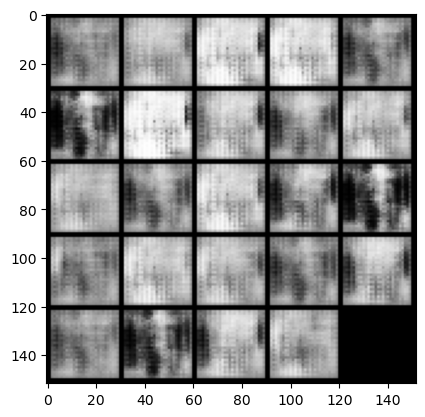

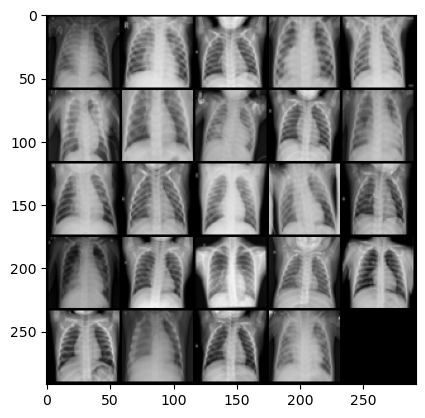

Discriminator loss: 0.0013857882022857667, generator loss: 0.0013901561498641968
Discriminator loss: 0.002771503210067749, generator loss: 0.002780579924583435
Discriminator loss: 0.004156984090805053, generator loss: 0.004171384334564209
Discriminator loss: 0.005542365789413452, generator loss: 0.005562071919441223
Discriminator loss: 0.006927559614181518, generator loss: 0.00695309853553772
Discriminator loss: 0.00831305956840515, generator loss: 0.008343241333961486
Discriminator loss: 0.009698231697082518, generator loss: 0.009733359336853027
Discriminator loss: 0.01108339738845825, generator loss: 0.011123539924621582
Discriminator loss: 0.012468642234802244, generator loss: 0.012513404011726379
Discriminator loss: 0.013853993773460386, generator loss: 0.01390286362171173
Discriminator loss: 0.015239444613456724, generator loss: 0.015291937112808227
Discriminator loss: 0.016624938845634457, generator loss: 0.016680709481239318
Discriminator loss: 0.01801036489009857, generator los

  0%|          | 0/218 [00:00<?, ?it/s]

Discriminator loss: 0.1081373575925827, generator loss: 0.10812601172924041
Discriminator loss: 0.10952279198169708, generator loss: 0.10951494359970092
Discriminator loss: 0.11090804159641265, generator loss: 0.11090425491333007
Discriminator loss: 0.11229335224628448, generator loss: 0.11229312765598297
Discriminator loss: 0.11367842066287993, generator loss: 0.11368247759342193
Discriminator loss: 0.1150635563135147, generator loss: 0.11507153856754301
Discriminator loss: 0.11644904100894926, generator loss: 0.11646018755435943
Discriminator loss: 0.11783433568477629, generator loss: 0.11784867978096007
Discriminator loss: 0.11921988761425016, generator loss: 0.11923673796653747
Discriminator loss: 0.12060556614398954, generator loss: 0.1206244386434555
Discriminator loss: 0.12199126064777371, generator loss: 0.12201176333427428
Discriminator loss: 0.1233773040771484, generator loss: 0.12339858031272888
Discriminator loss: 0.12476338684558866, generator loss: 0.12478492105007172
Dis

  0%|          | 0/218 [00:00<?, ?it/s]

Discriminator loss: 0.4103676270246507, generator loss: 0.41041982805728905
Discriminator loss: 0.411753076195717, generator loss: 0.4118089604377746
Discriminator loss: 0.41313837039470686, generator loss: 0.4131980156898498
Discriminator loss: 0.4145233221054078, generator loss: 0.41458727848529814
Discriminator loss: 0.4159082946777345, generator loss: 0.41597642135620116
Discriminator loss: 0.4172930295467378, generator loss: 0.41736589729785917
Discriminator loss: 0.4186776332855226, generator loss: 0.41875487661361693
Discriminator loss: 0.4200621252059938, generator loss: 0.4201436983346939
Discriminator loss: 0.42144635176658646, generator loss: 0.42153281807899473
Discriminator loss: 0.4228309500217439, generator loss: 0.42292089295387264
Discriminator loss: 0.42421560597419755, generator loss: 0.4243085587024688
Discriminator loss: 0.42560048580169696, generator loss: 0.4256956399679183
Discriminator loss: 0.4269854129552843, generator loss: 0.4270826686620712
Discriminator l

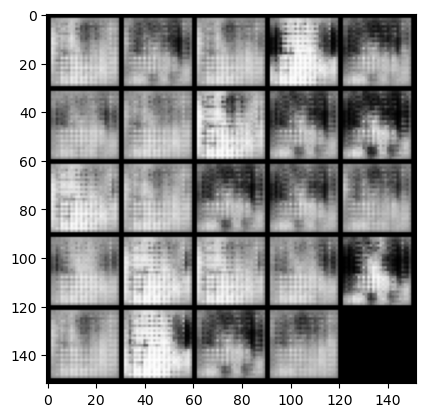

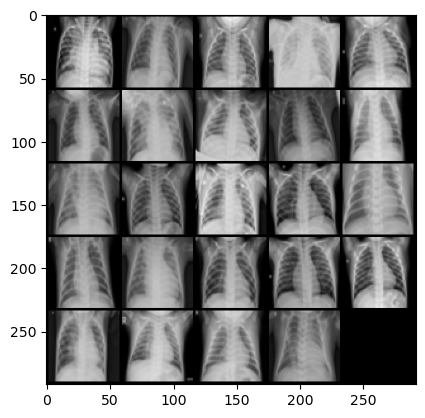

Discriminator loss: 0.0013865883350372315, generator loss: 0.0013866819143295288
Discriminator loss: 0.0027730329036712645, generator loss: 0.0027738058567047122
Discriminator loss: 0.004159470200538635, generator loss: 0.004161149144172669
Discriminator loss: 0.0055455764532089235, generator loss: 0.005548907399177552
Discriminator loss: 0.006931977391242981, generator loss: 0.006936377048492432
Discriminator loss: 0.008318192839622499, generator loss: 0.008324264049530029
Discriminator loss: 0.009704171657562257, generator loss: 0.009712286949157715
Discriminator loss: 0.011090090274810793, generator loss: 0.011100572228431702
Discriminator loss: 0.01247626876831055, generator loss: 0.01248834478855133
Discriminator loss: 0.013862173318862917, generator loss: 0.013876643180847168
Discriminator loss: 0.015248170614242556, generator loss: 0.015264641165733337
Discriminator loss: 0.016634188771247865, generator loss: 0.016652810096740724
Discriminator loss: 0.01802027988433838, generato

  0%|          | 0/218 [00:00<?, ?it/s]

Discriminator loss: 0.019406284093856814, generator loss: 0.019428941607475284
Discriminator loss: 0.020792405843734745, generator loss: 0.0208166196346283
Discriminator loss: 0.022178580522537236, generator loss: 0.02220426440238953
Discriminator loss: 0.02356483602523804, generator loss: 0.023591717362403872
Discriminator loss: 0.024951012611389163, generator loss: 0.024979232072830204
Discriminator loss: 0.026337342500686648, generator loss: 0.02636652219295502
Discriminator loss: 0.027723468303680422, generator loss: 0.027754012465476992
Discriminator loss: 0.029109855413436893, generator loss: 0.029140830278396607
Discriminator loss: 0.0304961953163147, generator loss: 0.030527762174606322
Discriminator loss: 0.03188263201713562, generator loss: 0.03191447865962982
Discriminator loss: 0.03326904773712158, generator loss: 0.03330114960670471
Discriminator loss: 0.034655437707901, generator loss: 0.03468781054019928
Discriminator loss: 0.03604185390472412, generator loss: 0.03607428

  0%|          | 0/218 [00:00<?, ?it/s]

Discriminator loss: 0.32164295530319204, generator loss: 0.3217590616941453
Discriminator loss: 0.32302832055091846, generator loss: 0.32314952230453503
Discriminator loss: 0.32441360855102525, generator loss: 0.3245399045944215
Discriminator loss: 0.3257990524768828, generator loss: 0.32593014562129985
Discriminator loss: 0.3271847183704375, generator loss: 0.32731968820095075
Discriminator loss: 0.32857044363021837, generator loss: 0.3287089880704881
Discriminator loss: 0.3299559938907622, generator loss: 0.33009825229644785
Discriminator loss: 0.33134175157546986, generator loss: 0.33148717200756084
Discriminator loss: 0.3327273497581481, generator loss: 0.33287602949142464
Discriminator loss: 0.33411325812339776, generator loss: 0.334264183163643
Discriminator loss: 0.3354993897676467, generator loss: 0.3356516680717469
Discriminator loss: 0.33688568949699393, generator loss: 0.33703899443149576
Discriminator loss: 0.3382718400955199, generator loss: 0.3384262429475785
Discriminato

In [203]:
# Training the GAN
gan = GAN(z_dim = 10, im_chan = 1, hidden_dim = 64)
gan.train_step(train_dataloader, 25, 0)

# GAN - Synthetic Data

# Optimization - Tips and tricks

1. [Wasserstein GAN with Gradient Penalty (WGAN-GP) ](https://github.com/amanchadha/coursera-gan-specialization/blob/main/C1%20-%20Build%20Basic%20Generative%20Adversarial%20Networks/Week%203/C1W3_WGAN_GP.ipynb)
- Specifically, you'll use a special kind of loss function known as the W-loss, where W stands for Wasserstein, and gradient penalties to prevent mode collapse.
-  Remember that in WGAN-GP, you no longer use a discriminator that classifies fake and real as 0 and 1 but rather a critic that scores images with real numbers.
- Even on GPU, the training will run more slowly than previous labs because the gradient penalty requires you to compute the gradient of a gradient -- this means potentially a few minutes per epoch! For best results, run this for as long as you can while on GPU.
- One important difference from earlier versions is that you will update the critic multiple times every time you update the generator This helps prevent the generator from overpowering the critic. Sometimes, you might see the reverse, with the generator updated more times than the critic. This depends on architectural (e.g. the depth and width of the network) and algorithmic choices (e.g. which loss you're using).
- WGAN-GP isn't necessarily meant to improve overall performance of a GAN, but just increases stability and avoids mode collapse. In general, a WGAN will be able to train in a much more stable way than the vanilla DCGAN from last assignment, though it will generally run a bit slower. You should also be able to train your model for more epochs without it collapsing.
2. [Conditional GAN ](https://github.com/amanchadha/coursera-gan-specialization/blob/main/C1%20-%20Build%20Basic%20Generative%20Adversarial%20Networks/Week%204/C1W4A_Build_a_Conditional_GAN.ipynb)
- Conditioned on the digit to be generated (the class vector)
- Note that this assignment requires no changes to the architectures of the generator or discriminator, only changes to the data passed to both. The generator will no longer take z_dim as an argument, but input_dim instead, since you need to pass in both the noise and class vectors.

## 1. Wasserstein GAN 

### a. Creating a new class name critic (instead of discriminator)

In [187]:
class Critic(nn.Module): 
    '''
    This class is use such that we can use the Wasserstein distance
    '''
    def __init__(self, im_chan = 1, hidden_dim = 64):
        super(Critic, self).__init__()
        self.im_chan = im_chan
        self.hidden_dim = hidden_dim
        self.critic = nn.Sequential(
            self.critic_block(im_chan, hidden_dim),
            self.critic_block(hidden_dim, hidden_dim*2),
            self.critic_block(hidden_dim*2, 1, final_layer = True)
        )
    def critic_block(self, in_channels, out_channels, kernel_size=4, stride=2, final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size, stride),
                nn.BatchNorm2d(out_channels),
                nn.LeakyReLU(0.2, inplace=True),
            )
        else:
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size, stride)
                )
        
    def forward(self, image):
        crit_pred = self.critic(image)
        return crit_pred.view(len(crit_pred), -1) #(-1, 1, 2, 2)    # (len(crit_pred), -1)

### b. Training initialization 
- lr: the learning rate
- beta_1, beta_2: the momentum terms
- c_lambda: weight of the gradient penalty
- crit_repeats: number of times to update the critic per generator update - there are more details about this in the Putting It All Together section

#### Gradient Penalty
- Calculating the gradient penalty can be broken into two functions: (1) compute the gradient with respect to the images and (2) compute the gradient penalty given the gradient.

- You can start by getting the gradient. The gradient is computed by first creating a mixed image. This is done by weighing the fake and real image using epsilon and then adding them together. Once you have the intermediate image, you can get the critic's output on the image. Finally, you compute the gradient of the critic score's on the mixed images (output) with respect to the pixels of the mixed images (input). You will need to fill in the code to get the gradient wherever you see None. There is a test function in the next block for you to test your solution.

In [192]:
display_step = 50

class GAN_Critic(nn.Module): 
    def __init__(self, z_dim, im_chan, hidden_dim): 
        super(GAN_Critic, self).__init__()

        beta_1 = 0.5
        beta_2 = 0.999
        lr = 0.0002
        self.c_lambda = 10
        self.crit_repeats = 5

        self.z_dim = z_dim
        self.im_chan = im_chan
        self.hidden_dim = hidden_dim
        self.gen = Generator(z_dim)
        self.crit = Critic()
        self.gen_opt = torch.optim.Adam(self.gen.parameters(), lr = lr, betas = (beta_1, beta_2))
        self.crit_opt = torch.optim.Adam(self.crit.parameters(), lr = lr, betas = (beta_1, beta_2))
        self.criterion = nn.BCEWithLogitsLoss()

    def get_gradient(self, crit, real, fake, epsilon):
        '''
        Return the gradient of the critic's scores with respect to mixes of real and fake images.
        Parameters:
            crit: the critic model
            real: a batch of real images
            fake: a batch of fake images
            epsilon: a vector of the uniformly random proportions of real/fake per mixed image
        Returns:
            gradient: the gradient of the critic's scores, with respect to the mixed image
        '''
        mixed = real * epsilon + fake * (1 - epsilon)
        mixed_score = crit(mixed)
        gradient = torch.autograd.grad(
            inputs=mixed,
            outputs=mixed_score,
            grad_outputs=torch.ones_like(mixed_score),
            create_graph=True,
            retain_graph=True,
        )[0]
        return gradient
    
    def gradient_penalty(self, gradient):
        # Flatten the gradients so that each row captures one image
        gradient = gradient.view(len(gradient), -1)

        # Calculate the magnitude of every row
        gradient_norm = gradient.norm(2, dim=1)
        
        # Penalize the mean squared distance of the gradient norms from 1
        gp = torch.mean((gradient_norm - 1)**2)
        return gp
    
    def loss_critics(self, real, fake, gp, c_lambda):
        real_crit = self.crit(real)
        fake_crit = self.crit(fake)
        crit_loss = torch.mean(fake_crit) - torch.mean(real_crit) + c_lambda * gp
        return crit_loss
    
    def loss_generators(self, fake_crit):
        gen_loss = -1. * torch.mean(fake_crit)
        return gen_loss
    
    def weights_init(self, m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
            torch.nn.init.normal_(m.weight, 0.0, 0.02)
        if isinstance(m, nn.BatchNorm2d):
            torch.nn.init.normal_(m.weight, 0.0, 0.02)
            torch.nn.init.constant_(m.bias, 0)

    def train_step(self, train_dataloader, display_step, cur_step):

        EPOCHS = 25
        display_step = 500
        cur_step = 0
        device = 'cpu'
        gen = self.gen.to(device)
        crit = self.crit.to(device)
        mean_discriminator_loss = 0
        mean_generator_loss = 0
    
        # You initialize the weights to the normal distribution
        # with mean 0 and standard deviation 0.02
        gen = self.gen.apply(self.weights_init)
        crit = self.crit.apply(self.weights_init)
        
        for epoch in range(EPOCHS):
            #real_images, real_labels = next(iter(train_dataloader))
            for real_images, _ in tqdm(train_dataloader):
                
                real = real_images.to(device)
                batch_size = len(real_images)
                # Real images
                noise = torch.randn(batch_size, self.z_dim, device = device)
                # Generate fake images
                print(real.size())
                mean_iteration_critic_loss = 0
                for _ in range(self.crit_repeats):
                    # Train the discriminator
                    critic_opt = self.crit_opt
                    critic_opt.zero_grad()
                    
                    generated_images = gen(noise)
                    crit_pred_fake = crit(generated_images.detach())
                    crit_pred_real = crit(real)
                    print(generated_images.size())  
                    print(crit_pred_fake.size())
                    print(crit_pred_real.size())

                    # Calculate the gradient penalty
                    epsilon = torch.rand(len(real), 1, 1, 1, device=device, requires_grad=True)
                    gradient = self.get_gradient(crit, real, generated_images.detach(), epsilon)
                    gp = self.gradient_penalty(gradient)
                    
                    # Calculate the loss for the discriminator
                    crit_loss = self.loss_critics(crit_pred_real, crit_pred_fake, gp, self.c_lambda)
                    
                    # Keep track of the average critic loss in this batch
                    mean_iteration_critic_loss += crit_loss.item() / self.crit_repeats
                    
                    crit_loss.backward(retain_graph=True)
                    critic_opt.step()
                
                # Append the losses and check the epoch time
                critic_losses += [mean_iteration_critic_loss]
                
                # Train the generator
                gen_opt = self.gen_opt
                gen_opt.zero_grad()
                generator = self.gen
                fake_2 = generator(noise)
                crit_fake_pred = self.crit(fake_2)
                generator_loss = self.loss_generators(crit_fake_pred)
                generator_loss.backward()   
                gen_opt.step()
                
                # Keep track of the average generator loss
                generator_losses += [generator_loss.item()]
                #mean_generator_loss += generator_loss.item() / display_step
                
                # Print losses
                print(f"Discriminator loss: {mean_discriminator_loss}, generator loss: {mean_generator_loss}")

                ### Visualization code ###
                if cur_step % display_step == 0 and cur_step > 0:
                    gen_mean = sum(generator_losses[-display_step:]) / display_step
                    crit_mean = sum(critic_losses[-display_step:]) / display_step
                    print(f"Step {cur_step}: Generator loss: {gen_mean}, critic loss: {crit_mean}")
                    show_tensor_images(generated_images)
                    show_tensor_images(real)
                    step_bins = 20
                    num_examples = (len(generator_losses) // step_bins) * step_bins
                    plt.plot(
                        range(num_examples // step_bins), 
                        torch.Tensor(generator_losses[:num_examples]).view(-1, step_bins).mean(1),
                        label="Generator Loss"
                    )
                    plt.plot(
                        range(num_examples // step_bins), 
                        torch.Tensor(critic_losses[:num_examples]).view(-1, step_bins).mean(1),
                        label="Critic Loss"
                    )
                    plt.legend()
                    plt.show()

                cur_step += 1
        

In [193]:
# Train the GAN 
gan = GAN_Critic(z_dim = 10, im_chan = 1, hidden_dim = 64)
gan.train_step(train_dataloader, 25, 0)

  0%|          | 0/218 [00:00<?, ?it/s]

torch.Size([24, 1, 28, 28])
torch.Size([24, 1, 28, 28])
torch.Size([24, 1])
torch.Size([24, 1])


RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [24, 1]

# Evaluating GANs

1. [Fréchet Inception Distance (FID)](https://github.com/amanchadha/coursera-gan-specialization/blob/main/C2%20-%20Build%20Better%20Generative%20Adversarial%20Networks/Week%201/C2W1_Assignment.ipynb)
- Loss is Uninformative of Performance : One aspect that makes evaluating GANs challenging is that the loss tells us little about their performance. Unlike with classifiers, where a low loss on a test set indicates superior performance, a low loss for the generator or discriminator suggests that learning has stopped.
- No Clear Non-human Metric : If you define the goal of a GAN as "generating images which look real to people" then it's technically possible to measure this directly: you can ask people to act as a discriminator. However, this takes significant time and money so ideally you can use a proxy for this. There is also no "perfect" discriminator that can differentiate reals from fakes - if there were, a lot of machine learning tasks would be solved 
- Fréchet Inception Distance (FID) was proposed as an improvement over Inception Score and still uses the Inception-v3 network as part of its calculation. However, instead of using the classification labels of the Inception-v3 network, it uses the output from an earlier layer—the layer right before the labels. This is often called the feature layer. Research has shown that deep convolutional neural networks trained on difficult tasks, like classifying many classes, build increasingly sophisticated representations of features going deeper into the network. For example, the first few layers may learn to detect different kinds of edges and curves, while the later layers may have neurons that fire in response to human faces.
- To get the feature layer of a convolutional neural network, you can replace the final fully connected layer with an identity layer that simply returns whatever input it received, unchanged. This essentially removes the final classification layer and leaves you with the intermediate outputs from the layer before.

## [Bias](https://github.com/amanchadha/coursera-gan-specialization/blob/main/C2%20-%20Build%20Better%20Generative%20Adversarial%20Networks/Week%202/C2W2_Assignment.ipynb)

Quantification
Finally, you can also quantitatively evaluate the degree to which these factors covary. Given a target index, for example corresponding to "male," you'll want to return the other features that covary with that target feature the most. You'll want to account for both large negative and positive covariances, and you'll want to avoid returning the target feature in your list of covarying features (since a feature will often have a high covariance with itself). You'll complete some helper functions first, each of which should be one or two lines long.

# [Variational Autoencoder (VAE)](https://github.com/amanchadha/coursera-gan-specialization/blob/main/C2%20-%20Build%20Better%20Generative%20Adversarial%20Networks/Week%202/C2W2_VAE.ipynb)

# [BigGAN](https://github.com/amanchadha/coursera-gan-specialization/blob/main/C2%20-%20Build%20Better%20Generative%20Adversarial%20Networks/Week%203/BigGAN.ipynb)
 BigGAN performs a conditional generation task, so unlike StyleGAN, it conditions on a certain class to generate results. BigGAN is based mainly on empirical results and shows extremely good results when trained on ImageNet and its 1000 classes.

The authors propose a several changes that improve state-of-the-art Inception Score (IS) and Frechet Inception Distance (FID), including:

Increasing batch size by a factor of 8, which improves IS by 46% and improves FID by 35%, but also induces complete mode collapse in training.
Increasing the number of convolutional channels by 1.5x, which improves IS by 21% and FID by 23%.
Using shared class-conditional embeddings 
 in BatchNorm layers, which reduces the number of parameters and increases IS by 2% and FID by 4%.
Adding skip connections from latent noise 
 by concatenating chunks of 
 to 
. This improves IS by 1% and FID by 5%.

## Parts
### Class-conditional Batch Normalization
BigGAN injects class-conditional information by parameterizing and   as linear transformations of the class embedding, c.

### [Self-Attention Block](https://arxiv.org/abs/1805.08318)
As you may already know, self-attention has been a successful technique in helping models learn arbitrary, long-term dependencies. Self-Attention Generative Adversarial Networks (Zhang et al. 2018) first introduced the self-attention mechanism into the GAN architecture. BigGAN augments its residual blocks with these attention blocks.

#### BigGAN-deep
Initially, the authors of the BigGAN paper didn't find much help in increasing the depth of the network. But they experimented further (research is always improving!) and added a few notes about an additional architecture, called BigGAN-deep. This modification of BigGAN is 4x deeper, sports a modified residual block architecture, and concatenates the entire 
 vector to 
 (as opposed to separate chunks at different resolutions).

Typically on a difficult and complex task that you're unlikely to overfit, you expect better performance when a model has more parameters, because it has more room to learn. Surprisingly, BigGAN-deep has fewer parameters than its BigGAN counterpart. Architectural optimizations such as using depthwise separable convolutions and truncating/concatenating channels in skip connections (as opposed to using pointwise convolutions) decrease parameters without trading expressivity.

For more details on the BigGAN-deep architecture, see Appendix B of the paper.

And as for the implementation of the BigGAN-deep variant, well, that's left as an exercise for the reader. You're a smart cookie, you'll figure it out! Just keep in mind that with great power comes great responsibility ;)

# [StyleGAN2](https://github.com/amanchadha/coursera-gan-specialization/blob/main/C2%20-%20Build%20Better%20Generative%20Adversarial%20Networks/Week%203/StyleGAN2.ipynb)

- Demodulation. The instance normalization of AdaIN in the original StyleGAN actually was producing “droplet artifacts” that made the output images clearly fake. AdaIN is modified a bit in StyleGAN2 to make this not happen. Below, Figure 1 from the StyleGAN2 paper is reproduced, showing the droplet artifacts in StyleGAN.
droplet artifacts example

- Path length regularization. “Perceptual path length” (or PPL, which you can explore in another optional notebook) was introduced in the original StyleGAN paper, as a metric for measuring the disentanglement of the intermediate noise space W. PPL measures the change in the output image, when interpolating between intermediate noise vectors w. You'd expect a good model to have a smooth transition during interpolation, where the same step size in  w maps onto the same amount of perceived change in the resulting image.
- Using this intuition, you can make the mapping from W space to images would be smoother, by encouraging a given change in w to correspond to a constant amount of change in the image. This is known as path length regularization, and as you might expect, included as a term in the loss function. This smoothness also made the generator model "significantly easier to invert"! Recall that inversion means going from a real or fake image to finding its w, so you can easily adapt the image's styles by controlling w.

- No progressive growing. While progressive growing was seemingly helpful for training the network more efficiently and with greater stability at lower resolutions before progressing to higher resolutions, there's actually a better way. Instead, you can replace it with 1) a better neural network architecture with skip and residual connections (which you also see in Course 3 models, Pix2Pix and CycleGAN), and 2) training with all of the resolutions at once, but gradually moving the generator's attention from lower-resolution to higher-resolution dimensions. So in a way, still being very careful about how to handle different resolutions to make training eaiser, from lower to higher scales.
